# Endurance - Seasonal cycle of Meteorological and Waves Data
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on May 14, 2020. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download METBK and WAVSS data from the Coastal Endurance Oregon Offshore Surface Mooring using the Machine-to-Machine (M2M) interface, create quick plots, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## Request Data from OOINet

**Coastal Endurance Oregon Offshore Surface Mooring (CE04OSSM)**
* METBK
    * Instrument: CE04OSSM-SBD11-06-METBKA000
    * Data stream: metbk_a_dcl_instrument_recovered
    * Parameters: air_temperature, sea_surface_temperature, eastward_wind_velocity, northward_wind_velocity, met_relwind_speed
* WAVSS
    * Instrument: CE04OSSM-SBD12-05-WAVSSA000
    * Data stream: wavss_a_dcl_statistics_recovered
    * Parameter: average_wave_height, max_wave_height, mean_wave_period
* Time range: 2016-07-01 to 2017-11-01
* Delivery method: recovered_host

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/extras'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for these instruments. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2016-07-01T00:00:00.000Z', '2017-11-01T00:00:00.000Z')

# WAVSS_url = request_data('CE04OSSM-SBD12-05-WAVSSA000', 'recovered_host', 'wavss_a_dcl_statistics_recovered',
#                          '2016-07-01T00:00:00.000Z', '2017-11-01T00:00:00.000Z')

# print('METBK_url = %s' %METBK_url)
# print('WAVSS_url = %s' %WAVSS_url)

METBK_url = https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200514T142055481Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html
WAVSS_url = https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200514T142055920Z-CE04OSSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/catalog.html


## Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200514T142055481Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
WAVSS_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200514T142055920Z-CE04OSSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

In [7]:
# Specify the variables of interest and get the data
METBKvars = ['air_temperature', 'sea_surface_temperature', 'met_relwind_speed']
WAVSSvars = ['average_wave_height', 'max_wave_height', 'mean_wave_period']

METBK_data, METBK_units = get_data(METBK_url, METBKvars)
WAVSS_data, WAVSS_units = get_data(WAVSS_url, WAVSSvars)

print(METBK_units)
print(WAVSS_units)

Appending data from files
Appending data from files
{'air_temperature': ['ºC'], 'sea_surface_temperature': ['ºC'], 'met_relwind_speed': ['m s-1']}
{'average_wave_height': ['m'], 'max_wave_height': ['m'], 'mean_wave_period': ['sec']}


In [8]:
# print out the first few lines of each dataset
METBK_data.head()

,time,air_temperature,sea_surface_temperature,met_relwind_speed
573205,2016-07-01 00:00:46.833999872,14.231,12.690,5.148835
573206,2016-07-01 00:01:51.073999872,14.238,12.688,5.049802
573207,2016-07-01 00:02:55.418000384,14.201,12.678,5.351794
573208,2016-07-01 00:04:01.635000320,14.223,12.678,5.752564
573209,2016-07-01 00:05:06.328000000,14.216,12.680,5.328686


In [9]:
WAVSS_data.head()

,time,average_wave_height,max_wave_height,mean_wave_period
9074,2016-07-01 00:23:02.638000128,0.75,1.72,4.6
9075,2016-07-01 01:23:02.684000256,0.82,1.82,4.9
9076,2016-07-01 02:23:02.762999808,0.75,1.96,4.6
9077,2016-07-01 03:23:03.783000064,0.91,2.10,4.5
9078,2016-07-01 04:23:01.828000256,0.89,2.20,4.4


## Quick Data Plots
First, let's make some quick data plots

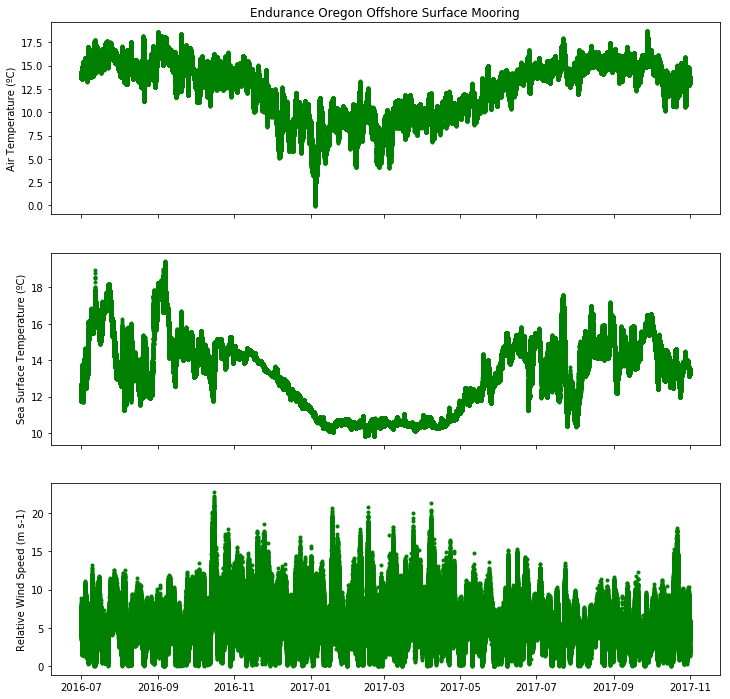

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
ax1.plot(METBK_data['time'], METBK_data['air_temperature'], 'g.')
ax2.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'g.')
ax3.plot(METBK_data['time'], METBK_data['met_relwind_speed'], 'g.')
ax1.set_title('Endurance Oregon Offshore Surface Mooring')
ax1.set_ylabel('Air Temperature ({})'.format(METBK_units['air_temperature'][0]))
ax2.set_ylabel('Sea Surface Temperature ({})'.format(METBK_units['sea_surface_temperature'][0]))
ax3.set_ylabel('Relative Wind Speed ({})'.format(METBK_units['met_relwind_speed'][0]));

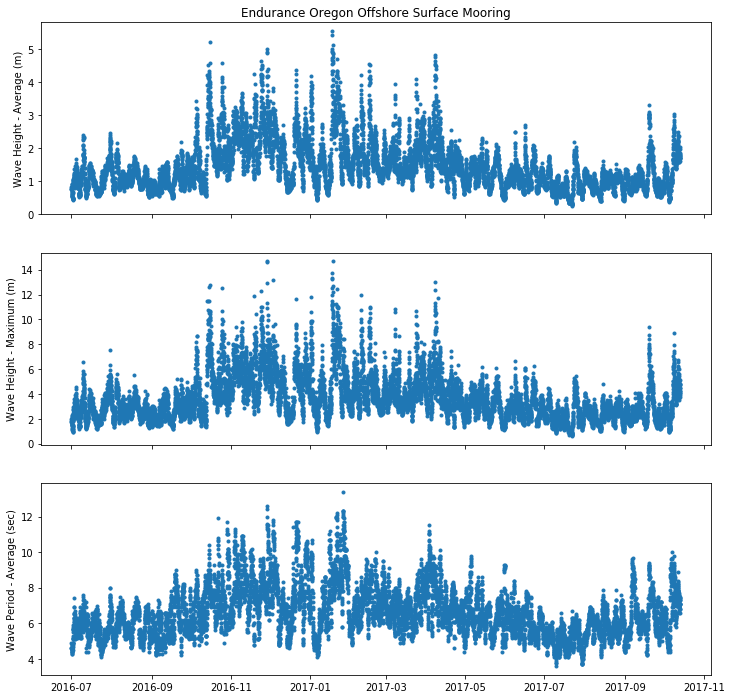

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
ax1.plot(WAVSS_data['time'], WAVSS_data['average_wave_height'], '.')
ax2.plot(WAVSS_data['time'], WAVSS_data['max_wave_height'], '.')
ax3.plot(WAVSS_data['time'], WAVSS_data['mean_wave_period'], '.')
ax1.set_title('Endurance Oregon Offshore Surface Mooring')
ax1.set_ylabel('Wave Height - Average ({})'.format(WAVSS_units['average_wave_height'][0]))
ax2.set_ylabel('Wave Height - Maximum ({})'.format(WAVSS_units['max_wave_height'][0]))
ax3.set_ylabel('Wave Period - Average ({})'.format(WAVSS_units['mean_wave_period'][0]));

These data depict a typical seasonal cycle of coastal winds and waves - lower air and sea surface temperatures in the winter paired with higher peak wind speeds. Waves are also generally larger in the winter, and larger waves generally have higher wave periods (it takes longer for the waves to cycle through a given point).

## 3. Merge and export
Now we'll merge and export the datasets as a .csv file. The METBK data are collected every second, so we will calculate hourly averages for that dataset to make the .csv file more manageable. The WAVSS instrument takes measurements for 20 minutes at the beginning of every hour, calculates the data products for that time interval and reports those calculations. Looking at the table below, in this instance the WAVSS data are reported on the 23rd minute of every hour. Since we want to merge these datasets, we want the timestamps for the METBK and WAVSS data to be the same. The easiest way to do that is to take hourly averages of both datasets - all this will do for the WAVSS data is reset the timestamps to the beginning of every hour (since the data are already reported hourly), and the METBK dataset will be downsampled. Then we will be able to merge easily.

In [12]:
WAVSS_data.head()

,time,average_wave_height,max_wave_height,mean_wave_period
9074,2016-07-01 00:23:02.638000128,0.75,1.72,4.6
9075,2016-07-01 01:23:02.684000256,0.82,1.82,4.9
9076,2016-07-01 02:23:02.762999808,0.75,1.96,4.6
9077,2016-07-01 03:23:03.783000064,0.91,2.10,4.5
9078,2016-07-01 04:23:01.828000256,0.89,2.20,4.4


In [13]:
# calculate hourly averages for both datasets
METBK_data_hourly = METBK_data.resample('H', on='time').mean().reset_index()
WAVSS_data_hourly = WAVSS_data.resample('H', on='time').mean().reset_index()

# rename the columns and add units
METBKcols = {'air_temperature': 'Air Temperature (deg_C)',
             'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
             'met_relwind_speed': 'Relative Wind Speed ({})'.format(METBK_units['met_relwind_speed'][0])}
METBK_data_hourly = METBK_data_hourly.rename(columns=METBKcols)

WAVSScols = {'average_wave_height': 'Wave Height Average ({})'.format(WAVSS_units['average_wave_height'][0]),
             'max_wave_height': 'Wave Height Maximum ({})'.format(WAVSS_units['max_wave_height'][0]),
             'mean_wave_period': 'Wave Period Average ({})'.format(WAVSS_units['mean_wave_period'][0])}
WAVSS_data_hourly = WAVSS_data_hourly.rename(columns=WAVSScols)

In [14]:
# merge the dataframes
merged = pd.merge(METBK_data_hourly, WAVSS_data_hourly, on='time', how='outer')
merged = merged.sort_values('time').reset_index(drop=True)  # make sure the dataframe is sorted by time

# round data to 2 decimal places
merged = merged.round(2)
merged.head()

,time,Air Temperature (deg_C),Sea Surface Temperature (deg_C),Relative Wind Speed (m s-1),Wave Height Average (m),Wave Height Maximum (m),Wave Period Average (sec)
0,2016-07-01 00:00:00,14.18,12.45,5.52,0.75,1.72,4.6
1,2016-07-01 01:00:00,14.22,12.28,5.72,0.82,1.82,4.9
2,2016-07-01 02:00:00,14.14,12.22,6.70,0.75,1.96,4.6
3,2016-07-01 03:00:00,14.11,12.15,6.89,0.91,2.10,4.5
4,2016-07-01 04:00:00,13.93,12.09,6.29,0.89,2.20,4.4


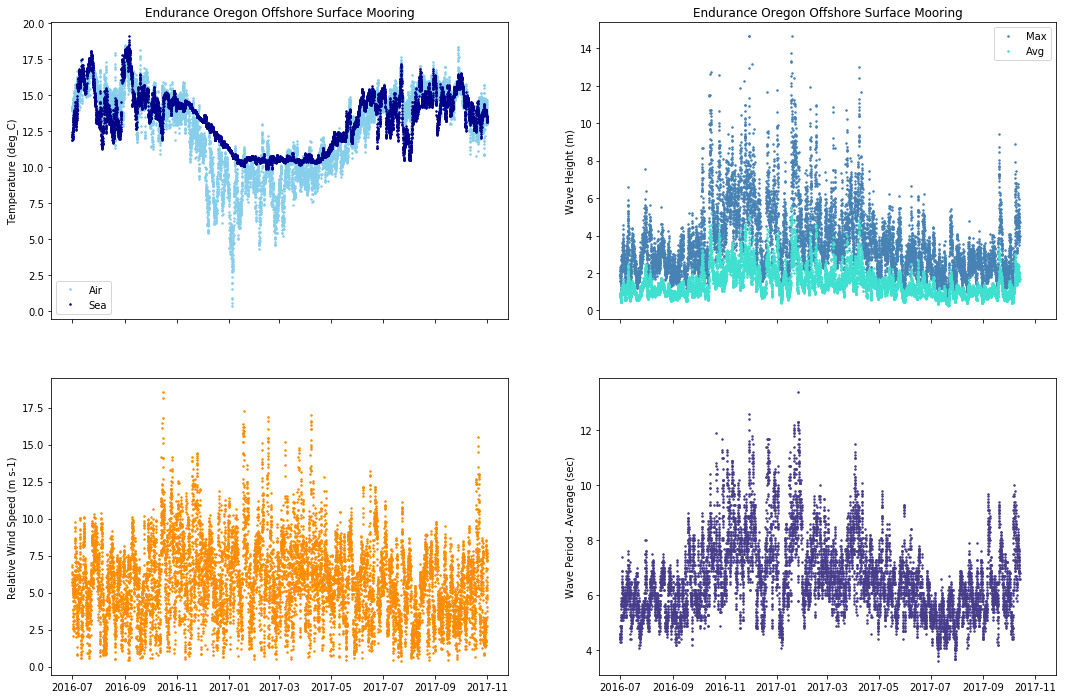

In [15]:
# plot the data again
fig, axs = plt.subplots(2,2, sharex=True, figsize = (18,12))
axs[0,0].plot(merged['time'], merged['Air Temperature (deg_C)'], '.', c='skyblue', markersize=3, label='Air')
axs[0,0].plot(merged['time'], merged['Sea Surface Temperature (deg_C)'], '.', c='darkblue', markersize=3, label='Sea')
axs[0,0].legend()
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Temperature (deg_C)')
axs[0,0].set_title('Endurance Oregon Offshore Surface Mooring')

axs[1,0].plot(merged['time'], merged['Relative Wind Speed (m s-1)'], '.', c='darkorange', markersize=3)
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('Relative Wind Speed (m s-1)')

axs[0,1].set_title('Endurance Oregon Offshore Surface Mooring')
axs[0,1].plot(merged['time'], merged['Wave Height Maximum (m)'], '.', c='steelblue', markersize=3, label='Max')
axs[0,1].plot(merged['time'], merged['Wave Height Average (m)'], '.', c='turquoise', markersize=3, label='Avg')
axs[0,1].legend()
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('Wave Height (m)')

axs[1,1].plot(merged['time'], merged['Wave Period Average (sec)'], '.', c='darkslateblue', markersize=3)
axs[1,1].set_xlabel('')
axs[1,1].set_ylabel('Wave Period - Average (sec)');

In [16]:
# export to .csv
merged.to_csv(os.path.join(save_dir, 'E03_Endurance_met_waves.csv'), index=False)